Doing some science-working through JL's list and my own ideas

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [50]:
model = Table.read('saved_models/trappist-1_model_var_res_v05.ecsv')
mw, mf = model['WAVELENGTH'], model['FLUX']

In [51]:
sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
w_sol, f_sol = sol_spec['wave']*10, sol_spec['flux']*100
w_sol, f_sol = w_sol[w_sol >= mw[0]], f_sol[w_sol >= mw[0]]
d_t1 = 12.1*u.pc 
d_sun = 1*u.au.to(u.pc)

#### scale by bolometric ps flux
r_t1 = 0.117*u.Rsun
#r_674 = 0.35*u.Rsun
t_t1= 2560*u.K
#t_674 = 3400*u.K
t_sun = 5777*u.k
bb_scale = ((u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2).value

###scale by 1 au flux
#au_scale = ((u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2).value


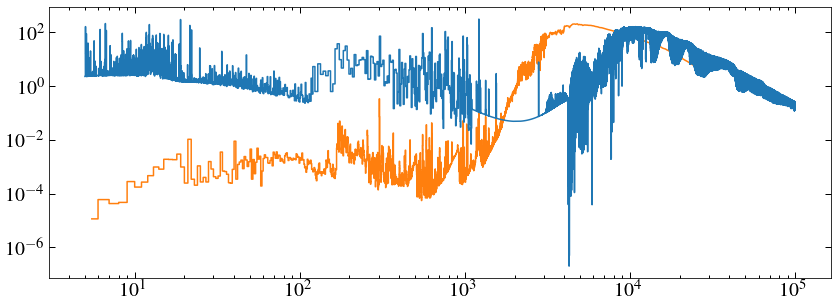

In [64]:
plt.step(mw, mf*bb_scale, where='mid')
plt.step(w_sol, f_sol, zorder=-1,where='mid')
plt.xscale('log')
plt.yscale('log')



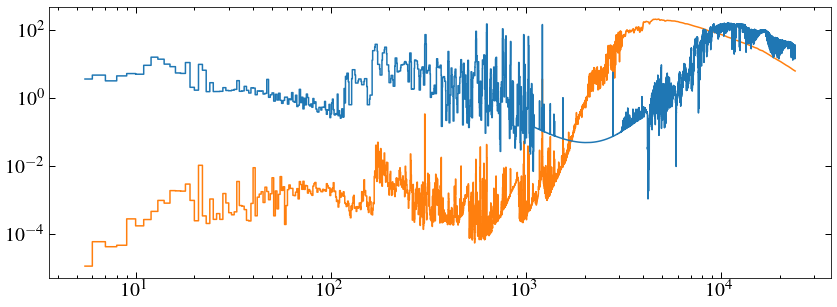

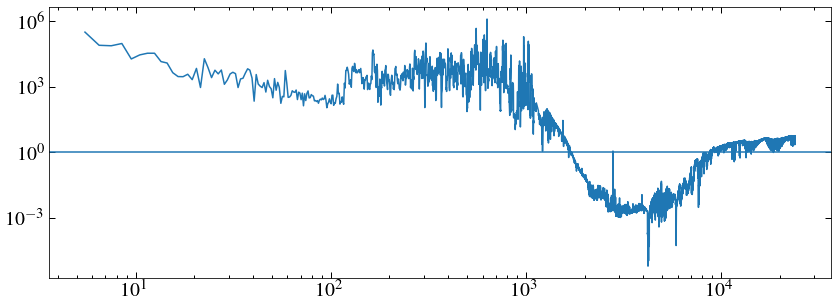

In [90]:
t1sw, t1sf = resample.bintogrid(mw, mf, newx=w_sol)
plt.step(t1sw, t1sf*bb_scale, where='mid')
plt.step(w_sol, f_sol, zorder=-1,where='mid')
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.plot(w_sol, t1sf*bb_scale/f_sol)
plt.xscale('log')
plt.yscale('log')
plt.axhline(1)


In [72]:
xuv_cut = 2000 #Angstroms this doesn't work, have to remove the blackbody
#t1_flux = np.trapz(mf, mw)
#t1_bb_flux = (const.sigma_sb *(4*np.pi*r_t1.to(u.cm)**2) * t_t1 ** 4 ).to(u.erg/u.s)/(4*np.pi*(d_t1.to(u.cm))**2)
#print(t1_flux, t1_bb_flux)

In [91]:
xuv_earth = np.trapz(f_sol[w_sol <=xuv_cut], w_sol[w_sol <=xuv_cut])
xuv_t1 = np.trapz(mf[mw <=xuv_cut], mw[mw <=xuv_cut])
print(xuv_earth)
print(xuv_earth/bb_scale)
print(xuv_t1)

99.868866
8.463134169746058e-15
6.985559046598151e-13


Habitable zone calculations from https://iopscience.iop.org/article/10.1088/2041-8205/787/2/L29

In [74]:
S_effsuns = [1.776,1.107,0.356,0.32]

a_all = [2.136e-4, 1.332e-4, 6.171e-5, 5.547e-5]
b_all = [2.533e-8, 1.58e-8, 1.698e-9, 1.526e-9]
c_all = [-1.332e-11, -8.308e-12,-3.198e-12,-2.874e-12]
d_all = [-3.097e-15,-1.931e-15,-5.575e-16,-5.011e-16]

t_star = t_t1.value - 5780 

l_t1 = 10**-3.28 #lsun

hzs = []
for s, a, b, c, d in zip(S_effsuns, a_all, b_all, c_all,d_all):
    Seff = s + a*t_star + b*t_star**2 + c*t_star**3 +d*t_star**4
    d_hz = (l_t1/Seff)**0.5
    hzs.append(d_hz)
print (hzs)
    

[0.018942461658199808, 0.023992418349443854, 0.04864997693231791, 0.05131643030421871]


In [75]:
#t1 planet semi-major axies
t1_a = np.array([0.01111, 0.01521, 0.02144, 0.02817,0.0371,0.0451,0.063])
t1_a_error_up = np.array([0.00034,0.00047, 0.00066,0.00083,0.0011,0.0014,0.027])
t1_a_error_down = np.array([0.00034,0.00047, 0.00063, 0.00087,0.0011,0.0014,0.013])
names  = ['b', 'c', 'd', 'e', 'f','g', 'h']

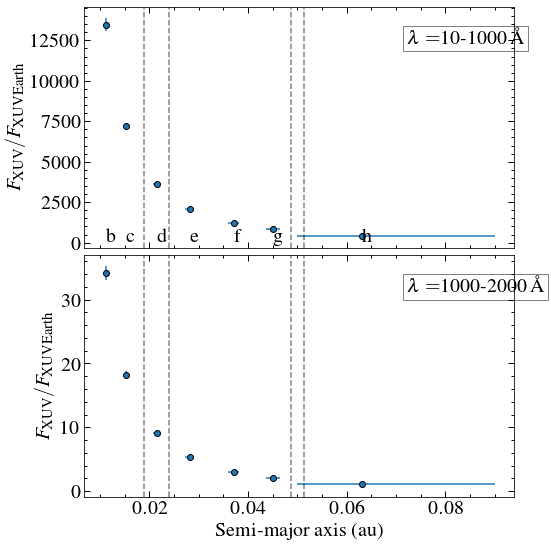

In [92]:
xuv_cuts = [10, 1000, 2000]
plt.figure(figsize=(8,8))

d_t1_au = d_t1.to(u.au).value
for i in range(len(xuv_cuts)-1):
    cut, cutu = xuv_cuts[i], xuv_cuts[i+1]
    plt.subplot(2,1,i+1)
    mask = (w_sol >cut) & (w_sol <cutu)
    xuv_earth = np.trapz(f_sol[mask], w_sol[mask])
    xuv_t1 = np.trapz(t1sf[mask], t1sw[mask])
    planet_xuv = []
    xuv_eu = []
    xuv_el = []
    for p, eu, el in zip(t1_a, t1_a_error_up, t1_a_error_down):
        xuv = (xuv_t1/xuv_earth)*(d_t1_au/p)**2
        xuv_up = xuv*(eu/p)
        xuv_down = xuv*(el/p)
        planet_xuv.append(xuv)
        xuv_eu.append(xuv_up)
        xuv_el.append(xuv_down)
    plt.errorbar(t1_a, np.array(planet_xuv), xerr=[t1_a_error_down, t1_a_error_up], yerr=[np.array(xuv_el), np.array(xuv_eu)], ls='none', marker='o',  mec='k')
    plt.ylabel('$F_{\mathrm{XUV}}/F_{\mathrm{XUV Earth}}$')
    if i ==0:
        [plt.annotate(name, (p, 45)) for name, p in zip(names, t1_a)]
       # plt.ylim(-0.9, 49)
        plt.xticks(visible=False)
    plt.annotate(r'$\lambda = ${0}\--{1}\,\AA'.format(cut, cutu), (0.75, 0.85), xycoords='axes fraction', bbox=dict(facecolor='none', edgecolor='k', alpha=0.5))
    [plt.axvline(hz, c='k', ls='--', alpha = 0.5) for hz in hzs]
   # plt.ylim(-0.9, 49)
plt.xlabel('Semi-major axis (au)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.03)
#plt.savefig('t1_planets_xuv.pdf', dpi=150)
#plt.savefig('t1_planets_xuv.png', dpi=150)

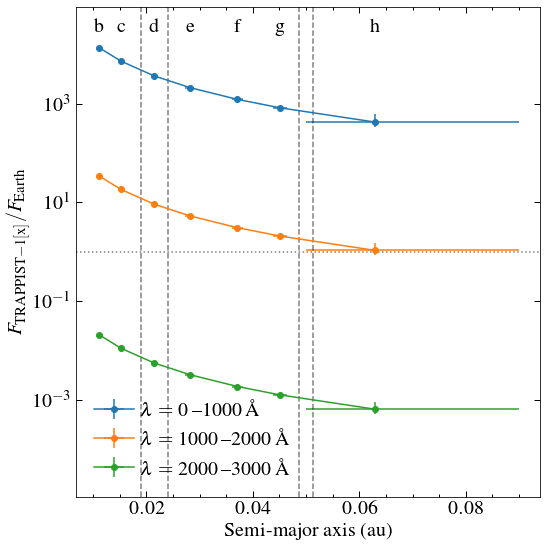

In [135]:
xuv_cuts = [0, 1000, 2000, 3000]
plt.figure(figsize=(8,8))

d_t1_au = d_t1.to(u.au).value
for i in range(len(xuv_cuts)-1):
    cut, cutu = xuv_cuts[i], xuv_cuts[i+1]
    #plt.subplot(2,1,i+1)
    mask = (w_sol >cut) & (w_sol <cutu)
    xuv_earth = np.trapz(f_sol[mask], w_sol[mask])
    xuv_t1 = np.trapz(t1sf[mask], t1sw[mask])
    planet_xuv = []
    xuv_eu = []
    xuv_el = []
    for p, eu, el in zip(t1_a, t1_a_error_up, t1_a_error_down):
        xuv = (xuv_t1/xuv_earth)*(d_t1_au/p)**2
        xuv_up = xuv*(eu/p)
        xuv_down = xuv*(el/p)
        planet_xuv.append(xuv)
        xuv_eu.append(xuv_up)
        xuv_el.append(xuv_down)
    plt.errorbar(t1_a, np.array(planet_xuv), xerr=[t1_a_error_down, t1_a_error_up], yerr=[np.array(xuv_el), np.array(xuv_eu)], marker='o', label = r'$\lambda = $ {0}\,--{1}\,\AA'.format(cut, cutu))
    plt.ylabel('$F_{\mathrm{TRAPPIST-1 [x]}}/F_{\mathrm{Earth}}$')
    #if i ==0:
[plt.annotate(name, (p, 0.95), xycoords=('data', 'axes fraction'), ha='center') for name, p in zip(names, t1_a)]
       # plt.ylim(-0.9, 49)
        #plt.xticks(visible=False)
    #plt.annotate(r'$\lambda = ${0}\--{1}\,\AA'.format(cut, cutu), (0.75, 0.85), xycoords='axes fraction', bbox=dict(facecolor='none', edgecolor='k', alpha=0.5))
[plt.axvline(hz, c='k', ls='--', alpha = 0.5) for hz in hzs]
plt.legend(loc=3)
   # plt.ylim(-0.9, 49)
plt.xlabel('Semi-major axis (au)')
#plt.subplots_adjust(hspace=0.03)
plt.yscale('log')
plt.ylim(1.1e-5, 9e4)
#plt.xlim(0.01, 0.12)
plt.axhline(1, ls=':',alpha = 0.5, c='k')

plt.tight_layout()

plt.savefig('../plots/t1_planets_xuv.pdf', dpi=150)
plt.savefig('../plots/t1_planets_xuv.png', dpi=150)

Semi-emp v Phoenix

In [58]:
mpath = '/home/david/work/muscles/trappist-1/sp_models/'
d = 12.14*u.pc
r = 0.117*const.R_sun
scale = (r/d.to(u.m))**2
mods = os.listdir(mpath)
mods

['TRAPPIST1_2A_fullres.txt',
 'TRAPPIST1_1A_fullres.txt',
 'TRAPPIST1_2B_fullres.txt']

In [59]:
mods = ['TRAPPIST1_1A_fullres.txt',
 'TRAPPIST1_2A_fullres.txt',
 'TRAPPIST1_2B_fullres.txt']

In [60]:
pw, pf = np.loadtxt(mpath+mods[0], unpack=True, skiprows=1)
pw1, pf1 = resample.bintogrid(pw, pf, dx=1.)
pmask = (pw1 > 4000) & (pw1 <= mw[-1])
mmask = mw > 4000
scale_to_muscles = (np.trapz(mf[mmask], mw[mmask])/np.trapz(pf1[pmask], pw1[pmask]))

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/david/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


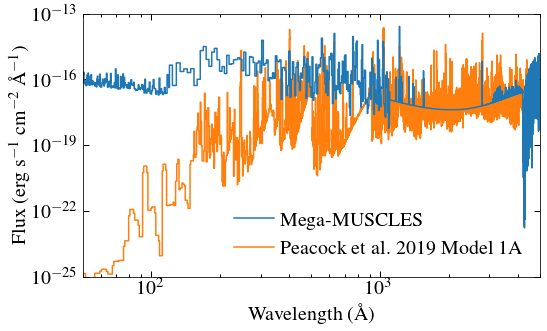

In [61]:
plt.figure(figsize=(8,5))
plt.step(mw,mf, where='mid', label='Mega-MUSCLES')
#for mod in mods[0:1]:
 #   pw, pf = np.loadtxt(mpath+mod, unpack=True, skiprows=1)
    #pf1 = interp1d(pw, pf*scale, fill_value='extra')
  #  pw1, pf1 = resample.bintogrid(pw, pf*scale, dx=1.)
plt.step(pw1[pf1>0], pf1[pf1>0]*scale_to_muscles, where='mid', zorder=-1, label = 'Peacock et al. 2019 Model 1A')

#plt.step(lw, lf, where='mid', label='EUV Estimate')
plt.xlim(50, 5000)
plt.ylim(1e-25, 1e-13)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
plt.savefig('T1_mm_v_phoenix.pdf', dpi=150)

In [62]:
bins = np.arange(0, 4000, 100)
bins

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900])

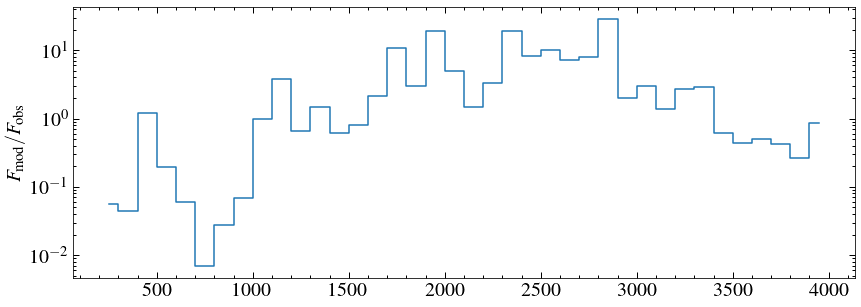

In [63]:
binsize=100
bins = np.arange(200, 4000, binsize)
ratio1 = []
ratio2 = []
ratio3 = []
for i in range(len(bins)):
    mmask = (mw > bins[i]) & (mw < bins[i]+binsize)
    pmask = (pw1> bins[i]) & (pw1 < bins[i]+binsize)
    mflux = np.trapz(mf[mmask], mw[mmask])
    pflux = np.trapz(pf1[pmask]*scale_to_muscles, pw1[pmask])
    ratio1.append(pflux/mflux)
plt.ylabel('$F_{\mathrm{mod}}/F_{\mathrm{obs}}$', size=20)
plt.step(bins+binsize/2, ratio1, where='mid')
plt.yscale('log')